1. **Creating a Custom Dataset for your files**

    A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the SatelliteImageClassification images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

    ```
    __init__
    ```
    The \__init__ function is run once when instantiating the Dataset object. We initialize the annotations file, and both transforms


    ```
    __len__
    ```
    The \__len__ function returns the number of samples in our dataset.


    ```
    __getitem__
    ```
    The \__getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.
    

In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from collections import Counter

# Mapping จากชื่อคลาสไปยัง index
classes = ('161', '162', '163', '164', '167', '168', '169', '170', '171', '173', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195')

class_to_idx = {'161': 0, '162': 1, '163': 2, '164': 3, '167': 4, '168': 5, '169': 6, '170': 7, '171': 8, '173': 9, 
                '175': 10, '176': 11, '177': 12, '178': 13, '179': 14, '180': 15, '181': 16, '182': 17, '183': 18, 
                '184': 19, '185': 20, '186': 21, '187': 22, '188': 23, '189': 24, '190': 25, '191': 26, '192': 27, 
                '193': 28, '194': 29, '195': 30}

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform if transform else transforms.ToTensor()
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx, 0]  # ชื่อไฟล์ของรูปภาพ
        label = self.img_labels.iloc[idx, 1]  # คลาสของรูปภาพ

        # แปลง label เป็น string เพื่อใช้กับ os.path.join()
        img_path = os.path.join(self.img_dir, str(label), img_name)

        # เปิดรูปภาพด้วย PIL
        image = Image.open(img_path).convert('RGB')

        # แปลง label จากชื่อคลาสเป็น index
        label = class_to_idx[str(label)]

        # ใช้การแปลง (transform) กับภาพ
        if self.transform:
            image = self.transform(image)

        # ใช้ target_transform ถ้ามี
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    - Preparing your data for training with DataLoaders

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from PIL import Image
import torch
from sklearn.model_selection import KFold

batch_size = 32
k_folds = 5  # กำหนดจำนวน folds
random_seed = 42

annotations_file = './train_annotations.csv'
data = pd.read_csv(annotations_file)

# Define transforms (ปรับขนาดภาพและแปลงเป็น tensor)
preproc = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image
    transforms.ToTensor(),  
    transforms.RandomRotation(degrees=10),  # Random rotation
    transforms.GaussianBlur(kernel_size=3),  # Add noise
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33)),  # Randomly erase part of the image
    transforms.ConvertImageDtype(torch.float32),  # Convert to float32 dtype
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize for grayscale
])

# Initialize Dataset
training_data = CustomImageDataset(annotations_file="./train_annotations.csv", img_dir="./thaicharecter", transform=preproc)

# Initialize KFold
kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

# Training loop for K-Fold Cross Validation
for fold, (train_indices, val_indices) in enumerate(kf.split(training_data)):
    print(f'Fold {fold+1}/{k_folds}')
    
    # Subset ข้อมูลตาม fold
    train_subset = Subset(training_data, train_indices)
    val_subset = Subset(training_data, val_indices)
    
    # Define DataLoaders สำหรับแต่ละ fold
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

    # Print the size of the train and validation sets
    print(f'Training samples in fold {fold+1}: {len(train_subset)}')
    print(f'Validation samples in fold {fold+1}: {len(val_subset)}')

    # You can now use train_dataloader and val_dataloader in your training loop
    # ใช้ train_dataloader และ val_dataloader ในการเทรนและวาลิเดตโมเดล


Fold 1/5
Training samples in fold 1: 15360
Validation samples in fold 1: 3840
Fold 2/5
Training samples in fold 2: 15360
Validation samples in fold 2: 3840
Fold 3/5
Training samples in fold 3: 15360
Validation samples in fold 3: 3840
Fold 4/5
Training samples in fold 4: 15360
Validation samples in fold 4: 3840
Fold 5/5
Training samples in fold 5: 15360
Validation samples in fold 5: 3840


    - Show sample image from the DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


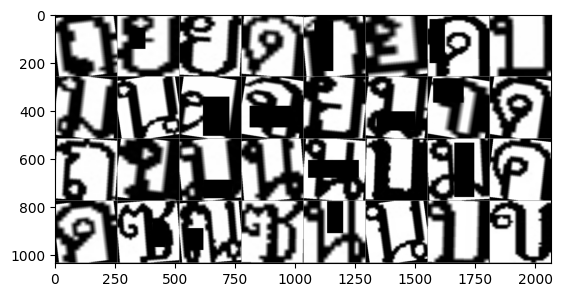

182   194   194   180  


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# ฟังก์ชันสำหรับ unnormalize และแสดงภาพ
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# ตัวอย่าง classes (คุณสามารถเปลี่ยนเป็นคลาสที่คุณใช้งานจริง)

# ดึงข้อมูล batch จาก dataloader
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# แสดงภาพ
imshow(torchvision.utils.make_grid(images))

# แสดงชื่อคลาสของภาพที่แสดง
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

2. Define a Convolutional Neural Network

In [4]:
from torchvision.models import densenet121, DenseNet121_Weights
import torch.nn as nn

# โหลด DenseNet121 ที่ pretrained บน ImageNet
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

# เปลี่ยนเลเยอร์ classifier เพื่อรองรับจำนวนคลาสในงานของคุณ
model.classifier = nn.Linear(1024, len(classes))  # จำนวนฟีเจอร์ของ DenseNet121 คือ 1024

# แสดงโมเดล
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

3. Define a Loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

4. Train the network

In [ ]:
import torch
from tqdm import tqdm  # Import tqdm สำหรับการแสดง progress bar

torch.manual_seed(0)

# Check if GPU (cuda) is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 4

# Training loop for K-Fold Cross Validation
for fold, (train_indices, val_indices) in enumerate(kf.split(training_data)):  # kf มาจากการกำหนด K-Fold ด้านบน
    print(f'Fold {fold+1}/{k_folds}')
    
    # Subset ข้อมูลตาม fold
    train_subset = Subset(training_data, train_indices)
    val_subset = Subset(training_data, val_indices)
    
    # Define DataLoaders สำหรับแต่ละ fold
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Move model to device (GPU or CPU)
    model.to(device)
    model.train()

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        model.train()  # Set model to training mode
        
        # Training phase
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({'Train Loss': running_loss / (batch_idx + 1)})

        # Validation phase (ไม่มีการอัปเดต weights ในช่วง validation)
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # No gradient calculation during validation
            for val_inputs, val_labels in val_dataloader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                # Forward pass
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                # Calculate accuracy
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        print(f'Fold {fold+1}, Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_dataloader):.4f}, '
              f'Validation Loss: {val_loss / len(val_dataloader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    print(f'Fold {fold+1} completed.')

print('Finished Training')


Fold 1/5


Fold 1, Epoch 1/4: 100%|██████████| 480/480 [36:00<00:00,  4.50s/it, Train Loss=0.814]


Fold 1, Epoch [1/4], Train Loss: 0.8143, Validation Loss: 0.1846, Validation Accuracy: 95.47%


Fold 1, Epoch 2/4: 100%|██████████| 480/480 [33:51<00:00,  4.23s/it, Train Loss=0.15] 


Fold 1, Epoch [2/4], Train Loss: 0.1500, Validation Loss: 0.0858, Validation Accuracy: 98.33%


Fold 1, Epoch 3/4: 100%|██████████| 480/480 [34:21<00:00,  4.30s/it, Train Loss=0.092] 


Fold 1, Epoch [3/4], Train Loss: 0.0920, Validation Loss: 0.0721, Validation Accuracy: 98.49%


Fold 1, Epoch 4/4: 100%|██████████| 480/480 [34:22<00:00,  4.30s/it, Train Loss=0.0708]


Fold 1, Epoch [4/4], Train Loss: 0.0708, Validation Loss: 0.0617, Validation Accuracy: 98.46%
Fold 1 completed.
Fold 2/5


Fold 2, Epoch 1/4: 100%|██████████| 480/480 [34:23<00:00,  4.30s/it, Train Loss=0.057] 


Fold 2, Epoch [1/4], Train Loss: 0.0570, Validation Loss: 0.0506, Validation Accuracy: 98.88%


Fold 2, Epoch 2/4: 100%|██████████| 480/480 [34:22<00:00,  4.30s/it, Train Loss=0.0502]


Fold 2, Epoch [2/4], Train Loss: 0.0502, Validation Loss: 0.0510, Validation Accuracy: 98.80%


Fold 2, Epoch 3/4: 100%|██████████| 480/480 [34:23<00:00,  4.30s/it, Train Loss=0.0444]


Fold 2, Epoch [3/4], Train Loss: 0.0444, Validation Loss: 0.0531, Validation Accuracy: 98.72%


Fold 2, Epoch 4/4: 100%|██████████| 480/480 [34:23<00:00,  4.30s/it, Train Loss=0.0418]


Fold 2, Epoch [4/4], Train Loss: 0.0418, Validation Loss: 0.0488, Validation Accuracy: 98.93%
Fold 2 completed.
Fold 3/5


Fold 3, Epoch 1/4: 100%|██████████| 480/480 [34:24<00:00,  4.30s/it, Train Loss=0.0427]


Fold 3, Epoch [1/4], Train Loss: 0.0427, Validation Loss: 0.0348, Validation Accuracy: 98.98%


Fold 3, Epoch 2/4: 100%|██████████| 480/480 [34:23<00:00,  4.30s/it, Train Loss=0.0386]


Fold 3, Epoch [2/4], Train Loss: 0.0386, Validation Loss: 0.0379, Validation Accuracy: 99.09%


Fold 3, Epoch 3/4: 100%|██████████| 480/480 [34:22<00:00,  4.30s/it, Train Loss=0.0339]


Fold 3, Epoch [3/4], Train Loss: 0.0339, Validation Loss: 0.0298, Validation Accuracy: 99.24%


Fold 3, Epoch 4/4: 100%|██████████| 480/480 [34:26<00:00,  4.30s/it, Train Loss=0.0345]


Fold 3, Epoch [4/4], Train Loss: 0.0345, Validation Loss: 0.0310, Validation Accuracy: 99.19%
Fold 3 completed.
Fold 4/5


Fold 4, Epoch 1/4: 100%|██████████| 480/480 [35:10<00:00,  4.40s/it, Train Loss=0.0331]


Fold 4, Epoch [1/4], Train Loss: 0.0331, Validation Loss: 0.0223, Validation Accuracy: 99.24%


Fold 4, Epoch 2/4: 100%|██████████| 480/480 [34:47<00:00,  4.35s/it, Train Loss=0.0321]


Fold 4, Epoch [2/4], Train Loss: 0.0321, Validation Loss: 0.0248, Validation Accuracy: 99.27%


Fold 4, Epoch 3/4: 100%|██████████| 480/480 [34:22<00:00,  4.30s/it, Train Loss=0.0303]


Fold 4, Epoch [3/4], Train Loss: 0.0303, Validation Loss: 0.0239, Validation Accuracy: 99.32%


Fold 4, Epoch 4/4: 100%|██████████| 480/480 [34:27<00:00,  4.31s/it, Train Loss=0.0276]


Fold 4, Epoch [4/4], Train Loss: 0.0276, Validation Loss: 0.0278, Validation Accuracy: 99.22%
Fold 4 completed.
Fold 5/5


Fold 5, Epoch 1/4: 100%|██████████| 480/480 [34:19<00:00,  4.29s/it, Train Loss=0.0284]


Fold 5, Epoch [1/4], Train Loss: 0.0284, Validation Loss: 0.0158, Validation Accuracy: 99.56%


Fold 5, Epoch 2/4: 100%|██████████| 480/480 [34:14<00:00,  4.28s/it, Train Loss=0.0262]


Fold 5, Epoch [2/4], Train Loss: 0.0262, Validation Loss: 0.0178, Validation Accuracy: 99.61%


Fold 5, Epoch 3/4: 100%|██████████| 480/480 [34:28<00:00,  4.31s/it, Train Loss=0.026] 


Fold 5, Epoch [3/4], Train Loss: 0.0260, Validation Loss: 0.0197, Validation Accuracy: 99.40%


Fold 5, Epoch 4/4:  86%|████████▌ | 413/480 [29:55<04:56,  4.42s/it, Train Loss=0.0253]

save model


In [7]:
# Save model
torch.save(model.state_dict(), 'model.pt')

In [ ]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")
